# Problème 1 : Hexapode

In [1]:
from brian2 import *
%matplotlib inline

C:\Users\asus\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
INFO       Cache size for target "cython": 4978 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\asus\.cython\brian_extensions" directory. [brian2]


## Définition des pattes (neurones moteurs + neurones connecteurs)
Chaque patte comprend:
Trois neurones moteurs comme suit : 
* 0 : mouvement avant
* 1 : mouvement élevation de la patte
* 2 : mouvement arrière

Deux neurones connecteurs sont comme suit:
* 0 : connecteur pour la commande avant
* 1 : connecteur pour la commande arrière

La disposition des pattes est la suivante:
```
  \__/
1_|  |_0
3_|  |_2
5_|__|_4
```

**Arnaud**

> Dans la cellule suivante on définit dans un premier temps les équations qui seront utilisés dans la suite du problème. Ces équations ont été expliquées dans le poster. Puis on créé le groupe de neurones moteurs (3 fois le nombre de pattes) et le groupe des neurones connecteurs (2 fois le nombre de pattes).
Ensuite dans une boucle, on créé chaque patte en créant un sous groupe de trois neurones moteurs, un sous groupe de deux neurones connecteurs, en créant les synapses nécessaires et les moniteurs.
Enfin chaque patte est ajouté dans une liste qui contiendra toutes les pattes.

In [2]:
# 1----------------------------------------------Définition équations des neurones

start_scope()

eqsPrincipale = '''
dv/dt = ((s*int(v > 0 or s>0))+ I - v)/tauV  : 1
ds/dt = -s/tauS : 1
I : 1
tauV : second
tauS : second
'''
eqsSecondaire = '''
dv/dt = (I - v)/tau  : 1
tau = 10*ms : second
I : 1
'''
resetMoteur = '''
v=0
s=s*int(s>1.8)
'''

wiMoteur = -1 #Poids de la synapse inhibitrice inter-commande
wiConnMoteur = 1.8 #Poids de la synapse excitatrice connecteur-moteur


# 2----------------------------------------------Création des groupes de neurones et des synapses
pattes = []
nombrePattes = 6
neuronesMoteur = NeuronGroup(3*nombrePattes, eqsPrincipale, threshold='v>=0.9', reset=resetMoteur, method='euler')
neuronesMoteur.tauV = 10*ms
neuronesMoteur.tauS = 20*ms

neuronesConnecteur = NeuronGroup(2*nombrePattes, eqsSecondaire, threshold='v>=0.9', reset='v=0', method='exact')

for nb in range(nombrePattes):
    neuroneMoteur = neuronesMoteur[3*nb:3*nb+3]
    #Synapse inhibitrice entre le moteur avant (0) et le moteur arrière (2)
    SynMoteur = Synapses(neuroneMoteur, neuroneMoteur, on_pre='s += wiMoteur')
    SynMoteur.connect(i=0, j=2)
    SynMoteur.connect(i=2, j=0)
    statemonMoteur = StateMonitor(neuroneMoteur, ['v', 's'], record=True)
    spikemonMoteur = SpikeMonitor(neuroneMoteur)

    neuroneConnecteur = neuronesConnecteur[2*nb:2*nb+2]
    #Synapse exitatrice entre neurones connecteurs et neurones moteurs
    SynConnMoteur = Synapses(neuroneConnecteur, neuroneMoteur, on_pre='s += wiConnMoteur*(0.5+0.5*int(s<=0))')
    SynConnMoteur.connect(i=0, j=[0,1])
    SynConnMoteur.connect(i=1, j=[1,2])
    #statemonConnecteur = StateMonitor(neuroneConnecteur, 'v', record=True)
    spikemonConnecteur = SpikeMonitor(neuroneConnecteur)
    
    patte = {
        "neuroneMoteur": neuroneMoteur,
        "SynMoteur": SynMoteur,
        "statemonMoteur": statemonMoteur,
        "spikemonMoteur": spikemonMoteur,
        "neuroneConnecteur": neuroneConnecteur,
        "SynConnMoteur": SynConnMoteur,
        #"statemonConnecteur": statemonConnecteur,
        "spikemonConnecteur": spikemonConnecteur,        
    }
    pattes.append(patte)


## Définition des neurones commandes
Il y'a 4 neurones commandes comme suit:
* 0 : neurone commande avant
* 1 : neurone commande arrière
* 2 : neurone commande gauche
* 3 : neurone commande droite

**Yasmine**
> Après avoir défini les neurones connecteurs et moteurs, on essayera dans cette partie de définir les neurones commandes. En effet, le groupe de neurone qui commande les pattes est constitué de 4 neurones : un pour la commande "Avant", le deuxième pour la commande "Arrière", le troisième pour la commande "Gauche" et le dernier pour celle de "Droite". Comme ce qui précède , nous avons mis en place pour ce groupe un modèle d'équation de type LIF avec la présence de la variable s. 
Entre les commandes 0 et 1 ainsi qu'entre celles 2 et 3, nous avons fait des ihibitions mutuelles grâce à l'implémentation de synapses ihibitrices avec un poids négatif (-1 dans notre cas) afin de s'assurer que lorsqu'une commande se décharge l'autre va s'ihiniber ce qui est logique vu qu'on ne peut pas avoir en même temps un déplacement en avant et en arrière ou encore un déplacement à gauche et à droite.
Et au final, nous avons mis le tout dans un dictionnaire.

In [3]:
# ---------------------------------------------- Définition des neurones commande
neuroneCommande = NeuronGroup(4, eqsPrincipale, threshold='v>=0.9', reset='v=0', method='euler')
neuroneCommande.tauV = 20*ms
neuroneCommande.tauS = 20*ms
statemonCommande = StateMonitor(neuroneCommande, ['v', 's'], record=True)
spikemonCommande = SpikeMonitor(neuroneCommande)
#Synapse inhibitrice entre neurones commande
wiCommande = -1 #Poids de la synapse inhibitrice
SynCommande = Synapses(neuroneCommande, neuroneCommande, on_pre='s += wiCommande')
SynCommande.connect(i=0, j=1)
SynCommande.connect(i=1, j=0)
SynCommande.connect(i=2, j=3)
SynCommande.connect(i=3, j=2)

commandes = {
        "neuroneCommande": neuroneCommande,
        "statemonCommande": statemonCommande,
        "spikemonCommande": spikemonCommande,
    }


## Connexion entre neurones commande et pattes

**Yahya**

In [4]:
#tableau pour stocker les synapses crées
SynapseCommandeConnect = [] 

#Connection du groupe de neurone commande avec chaque patte à travers les sous grp neuroneConnecteur
for num, patte in enumerate(pattes): #énumérer pour avoir l'indice de la patte
    #Synapse excitatrice de neurone commande vers neurones connecteurs des pattes
    SynCommandeConnect = Synapses(commandes["neuroneCommande"], patte["neuroneConnecteur"], on_pre='v = 1')
    #Connection du neuroneCommande0(cmd avant) avec le neurone Connecteur0
    SynCommandeConnect.connect(i=0, j=0)
    #Connection du neuroneCommande1(cmd arrière) avec le neurone Connecteur1
    SynCommandeConnect.connect(i=1, j=1)
    
    #connections du neuroneCommande2(cmd gauche) avec les pattes de droites
    if num%2==0:
        SynCommandeConnect.connect(i=2, j=0)
    #connections du neuroneCommande3(cmd droite) avec les pattes de gauches
    else:
        SynCommandeConnect.connect(i=3, j=0)
    
    #pour avoir un mvt avant déphasé entre les pattes c'est un mvt de vague d'indice plus faible au plus grand
    #pour avoir un mvt arrière déphasé entre les pattes c'est un mvt de vague d'indice plus faible au plus grand
    SynCommandeConnect.delay[0:2,:] = 'num*15*ms'
    
    #retard d'une 1ms de plus des commandes gauche ou droite par rapport au cmd avant ou arrière 
    SynCommandeConnect.delay[2:4,0] = '(num*15+1)*ms'
    
    SynapseCommandeConnect.append(SynCommandeConnect)

## Exécution et visualisation


**Arnaud**

> Dans la cellule suivante un créé un network afin de pouvoir inclure tous les objets qui ne sont pas dans le namespace. Ensuite on 'store' l'état du network pour le réutiliser lors des simulations.
De plus dans cette cellule on définie deux fonctions qui permettront de visualiser les résultats. La fonction 'visualiser()' permet d'afficher dans une ligne verticale les instants de décharge du neurone commande et d'afficher les instants de décharge de chaque patte en utilisant un marqueur et une couleur différente en fonction du neurone moteur qui a déchargé. La fonction 'visualiserDetail()' prend en paramètre le sens du déplacement et permet de visualer l'évolution du potentiel du neurone commande correspondant ainsi que celui des deux premières pattes.

In [5]:
#Arnaud
net = Network(collect())
net.add(pattes)
net.add(SynapseCommandeConnect)
net.store('1')

colors = ["blue", "orange", "red"]
markers = ['>', '.', '<']

def visualiser():
    figure(figsize=(20, 6))
    for num, patte in enumerate(pattes):
        spikemon = patte["spikemonMoteur"]
        for t,j in zip(spikemon.t, spikemon.i):
            plot(t/ms, num, markers[j], color=colors[j])
    spikemon = commandes["spikemonCommande"]        
    for t,i in zip(spikemon.t, spikemon.i):
        axvline(t/ms, ls='--', c='blue' if (i==0) else 'red')

def visualiserDetail(avant = True):
    figure(figsize=(20, 6))
    statemonCommande = commandes["statemonCommande"]
    plot(statemonCommande.t/ms, statemonCommande.v[0 if (avant) else 1], '--', label='VNeuronecom')
    for num, patte in enumerate(pattes[:2]):
        label = 'Patte - '+str(num)
        statemon = patte["statemonMoteur"]
        plot(statemon.t/ms, statemon.v[0 if (avant) else 2], label=label)
    xlabel('Time (ms)')
    ylabel('v')
    legend(loc='best');

### Déplacement avant

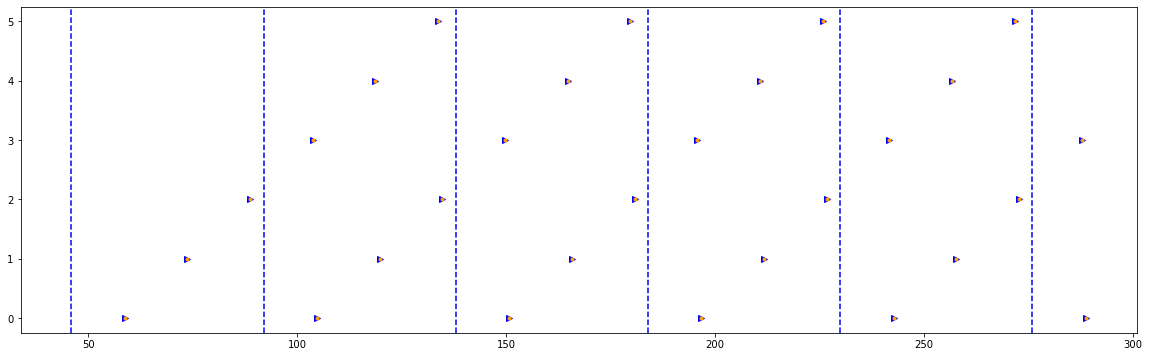

In [6]:
net.restore('1')
commandes["neuroneCommande"][0].I = 1
net.run(300*ms)

visualiser()

### Déplacement arrière

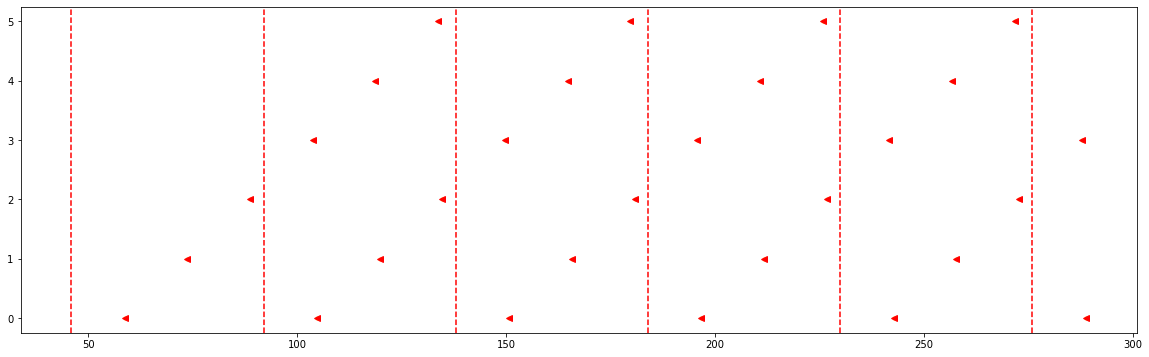

In [7]:
net.restore('1')
commandes["neuroneCommande"][1].I = 1
net.run(300*ms)

visualiser()

### Déplacement avant accéléré

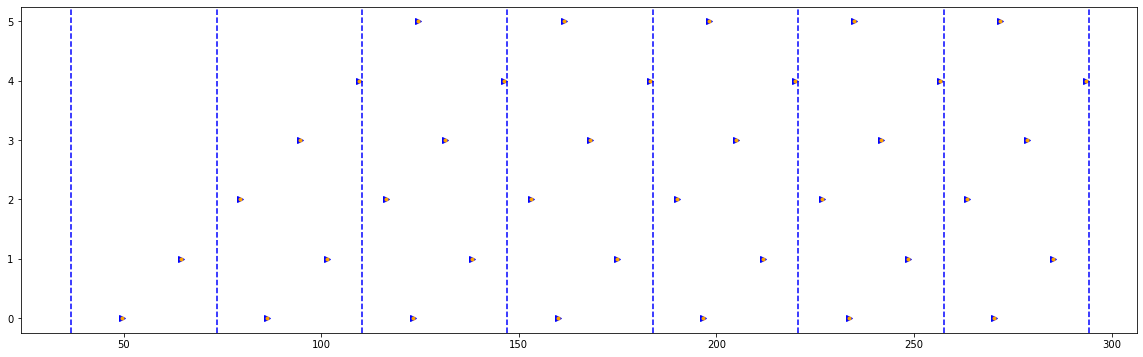

In [8]:
net.restore('1')
commandes["neuroneCommande"][0].I = 1
commandes["neuroneCommande"][0].tauV = 16*ms
net.run(300*ms)

visualiser()

### Déplacement avant & gauche

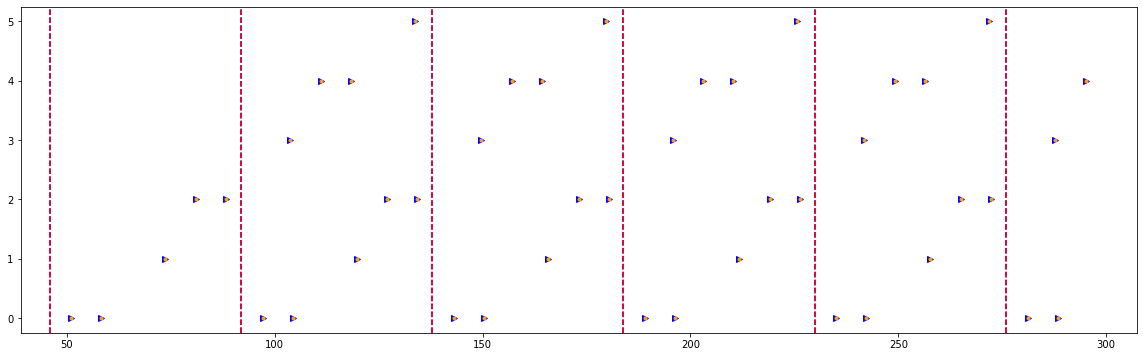

In [9]:
net.restore('1')
commandes["neuroneCommande"][0].I = 1
commandes["neuroneCommande"][2].I = 1
net.run(300*ms)

visualiser()

### Déplacement avant & droite

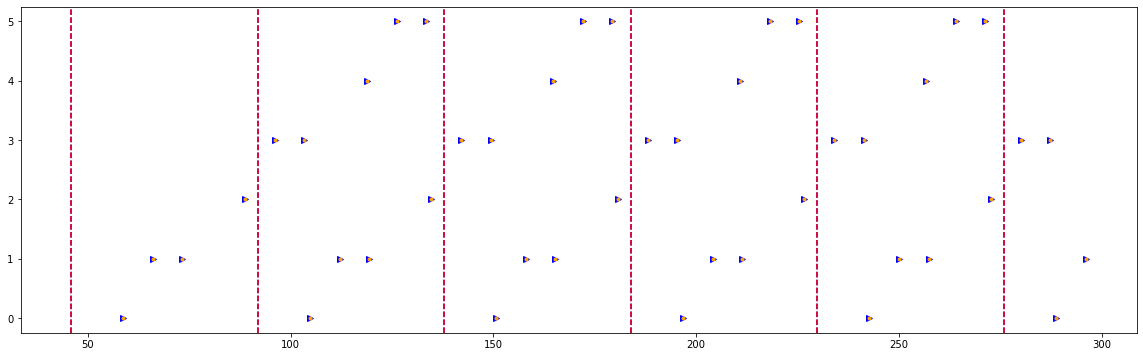

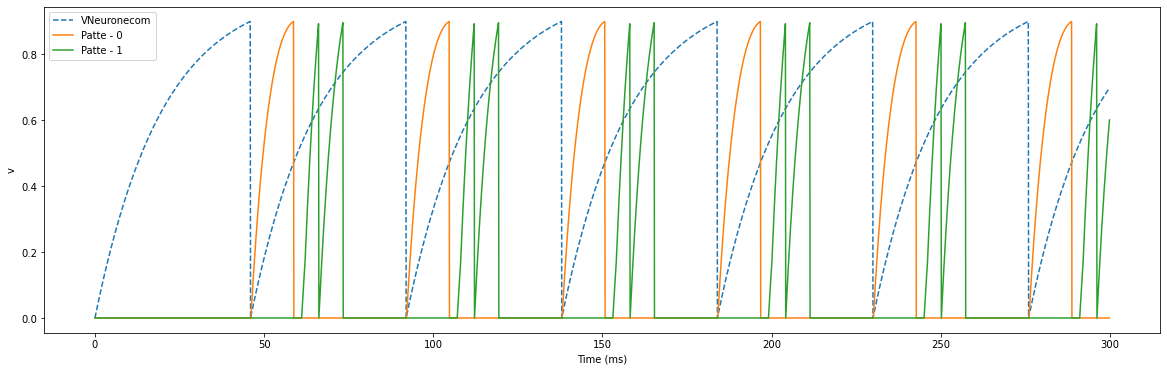

In [10]:
net.restore('1')
commandes["neuroneCommande"][0].I = 1
commandes["neuroneCommande"][3].I = 1
net.run(300*ms)

visualiser()
visualiserDetail()

## Partie 2 : (semi-autonome)
Pour que l'hexapode détecte les obstacles, nous avons mis en place 4 capteurs : 
- Capteur 0: quand ce capteur décharge (présence d'obstacle derrière l'hexapode) il permet à l'hexapode d'accélérer
- Capteur 1: quand ce capteur décharge (présence d'obstacle devant l'hexapode) il permet à l'hexapode de reculer à l'arrière
- Capteur 2: quand ce capteur décharge (présence d'obstacle à droite de l'hexapode) il permet à l'hexapode de se déplacer vers la gauche
- Capteur 3: quand ce capteur décharge (présence d'obstacle à gauche de l'hexapode) il permet à l'hexapode de se déplacer vers la droite


La disposition des capteurs est la suivante:
```
        [C1]
  
        \__/
      1_|  |_0
[C3]  3_|  |_2  [C2]
      5_|__|_4

        [C0]
```

### Définition des capteurs

**Yahya**

In [11]:
#définition des 4 capteurs
neuroneCapteurs = NeuronGroup(4, eqsSecondaire,threshold='v>0.9', reset='v = 0', method='exact')
statemonCapteur = StateMonitor(neuroneCapteurs, 'v', record=True)
spikemonCapteur = SpikeMonitor(neuroneCapteurs)

### Connection entre capteurs et neurones commandes

**Yahya**

In [12]:
SynCapteursCommande= Synapses(neuroneCapteurs, commandes["neuroneCommande"],'w : 1', on_pre='s_post += w')
#Capteur0 derrière permet d'accélérer
SynCapteursCommande.connect(i=0, j=0)
#Capteur1 devant permet reculer à l'arrière
SynCapteursCommande.connect(i=1, j=1)
#Capteur2 droite de se déplacer vers l'avant et gauche pour avoir un mvt de rotation vers la gauche
SynCapteursCommande.connect(i=2, j=[0,2])
#Capteur3 gauche de se déplacer vers l'avant et droite pour avoir un mvt de rotation vers la droite
SynCapteursCommande.connect(i=3, j=[0,3])

SynCapteursCommande.w = 1

#pour avoir un mvt accéleration on a choisit le 1.3 empiriquement
SynCapteursCommande.w[0,0] = 1.3


capteurs = {
        "neuroneCapteur": neuroneCapteurs,
        "statemonCapteur": statemonCapteur,
        "spikemonCapteur": spikemonCapteur,
    }

### Visualisation

**Yasmine**
> Dans cette partie, nous voulons visualiser nos résulats pour la partie semi-autonome. Pour se faire, nous avons restauré ce qui a été stocké dans le 1 puis on a ajouté les fonctions qui nous intéressent dans la partie 2: les capteurs et les synapses entre ces derniers et la commande. Ensuite, on a stocké de nouveau l’état actuel mais cette fois-ci dans un store 2 pour ensuite la restaurer et y revenir à chaque fois que l’on désire l’utiliser.

> La fonction définie ici "visualiserDetailCapteur est plus au moins similaire à celle mise en place dans la partie 1, ce qui diffère c'est juste au niveau de l'instruction if dans la boucle.

> Pour visualiser l'accélération par exemple, un simple restore de ce qui se trouve dans le store 2 fera l’affaire sans oublier d´ajouter le neurone capteur 0 (c'est lui qui va détecter un obstacle d'arrière), de mettre son I à 1 et de placer un run.
De même pour les autres capteurs, il suffit juste de modifier l'indice 0 par l'indice du capteur qu’on s’intéresse à visualiser son impact sur le mouvement après détection de l’obstacle d'un des 3 autres côtés (d'avant, de gauche et de droite).

In [13]:
net.restore('1')
net.add(capteurs)
net.add(SynCapteursCommande)
net.store('2')

def visualiserDetailCapteur(num):
    figure(figsize=(20, 6))
    statemonCommande = commandes["statemonCommande"]
    plot(statemonCommande.t/ms, statemonCommande.v[num], '--', label='Neuronecom')
    spikemon = capteurs["spikemonCapteur"]
    for t,j in zip(spikemon.t, spikemon.i):
        if(j==num):
            axvline(t/ms, ls='-')
    for numPatte, patte in enumerate(pattes[:2]):
        label = 'Patte - '+str(numPatte)
        statemon = patte["statemonMoteur"]
        plot(statemon.t/ms, statemon.v[0 if (num != 1) else 1], label=label)
    xlabel('Time (ms)')
    ylabel('v')
    legend(loc='best');

#### Activation capteur arrière => Accélération

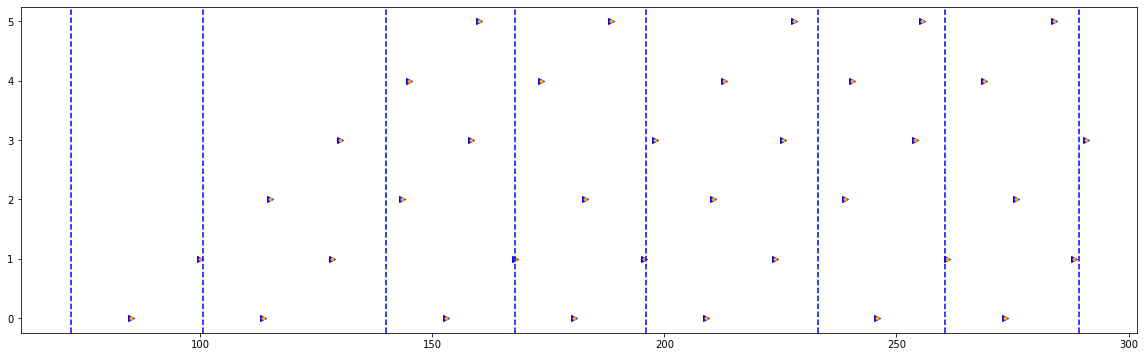

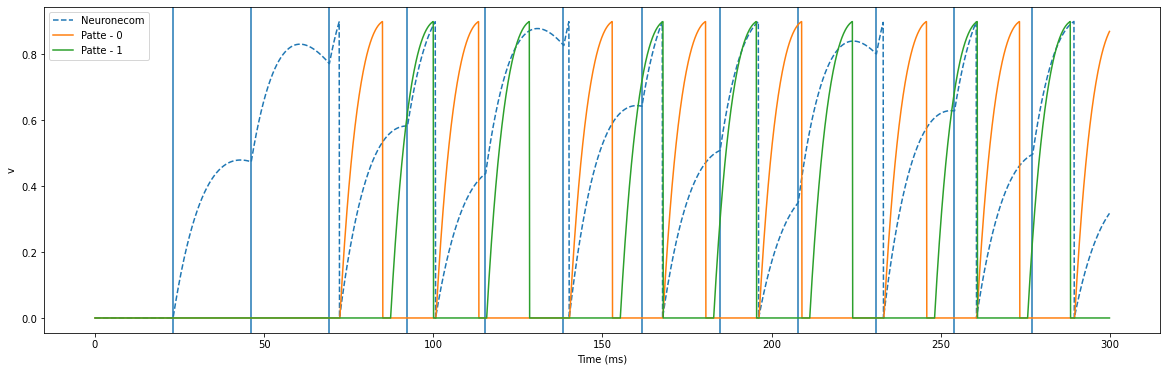

In [14]:
net.restore('2')
capteurs["neuroneCapteur"][0].I=1
net.run(300*ms)

visualiser()
visualiserDetailCapteur(0)

#### Activation capteur avant => marche arrière

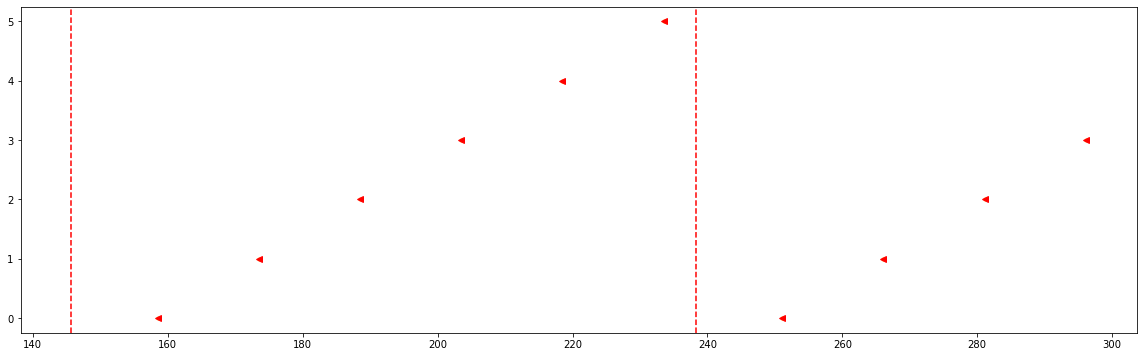

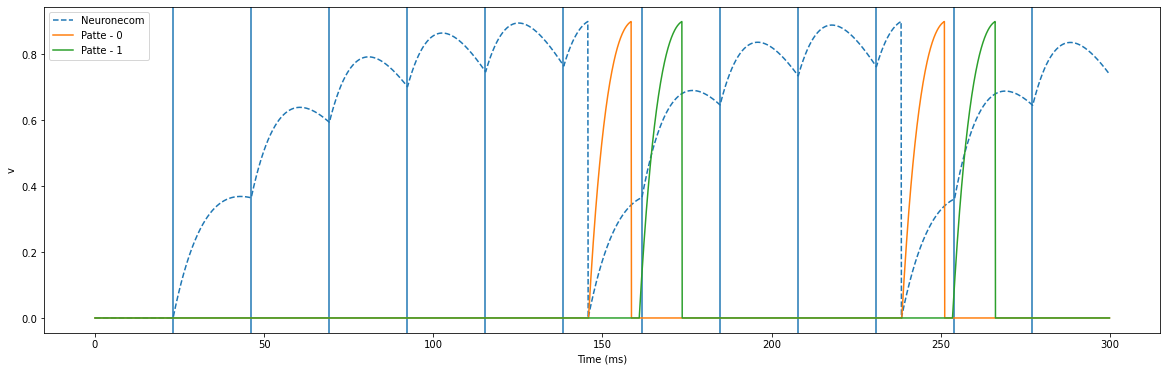

In [15]:
net.restore('2')
capteurs["neuroneCapteur"][1].I=1
net.run(300*ms)

visualiser()
visualiserDetailCapteur(1)

#### Activation capteur droit => déplacement vers la gauche

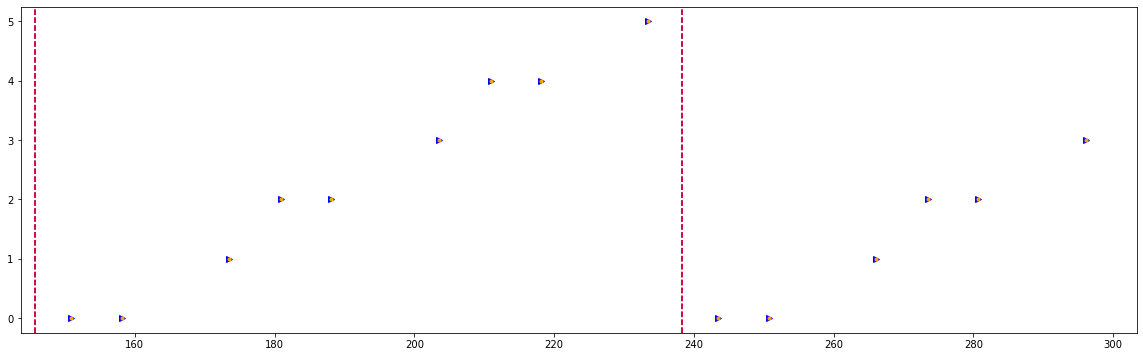

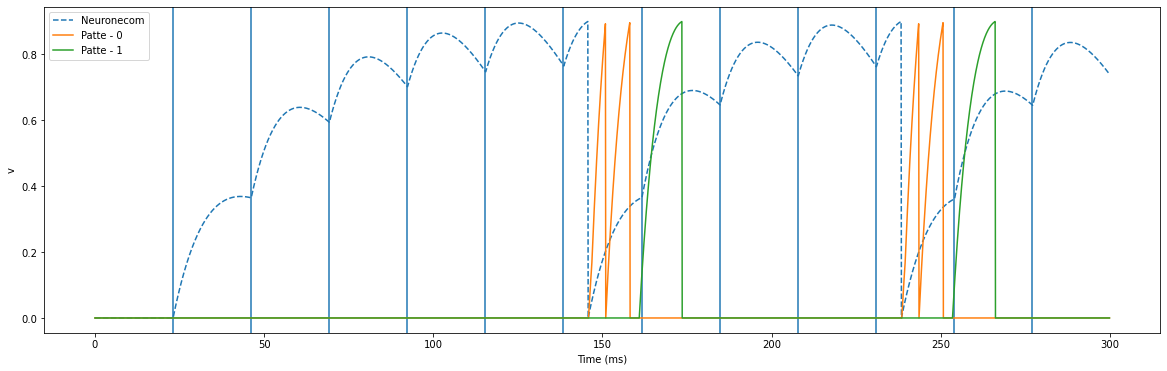

In [16]:
net.restore('2')
capteurs["neuroneCapteur"][2].I=1
net.run(300*ms)

visualiser()
visualiserDetailCapteur(2)

#### Activation capteur gauche => déplacement vers la droite

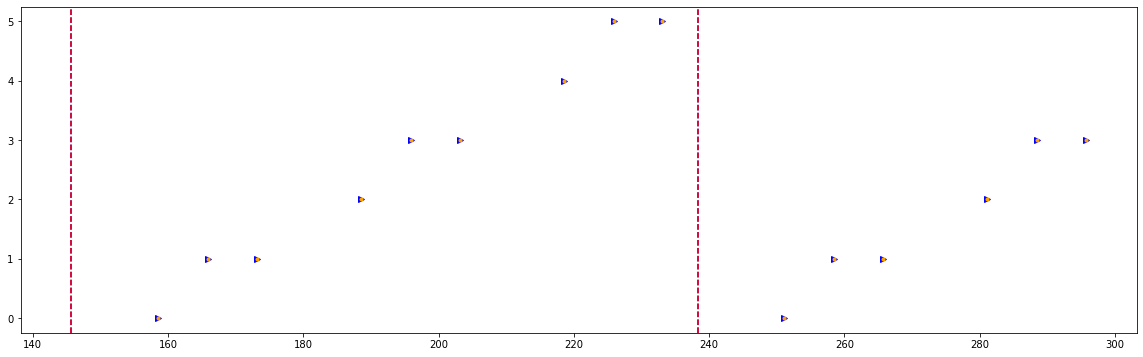

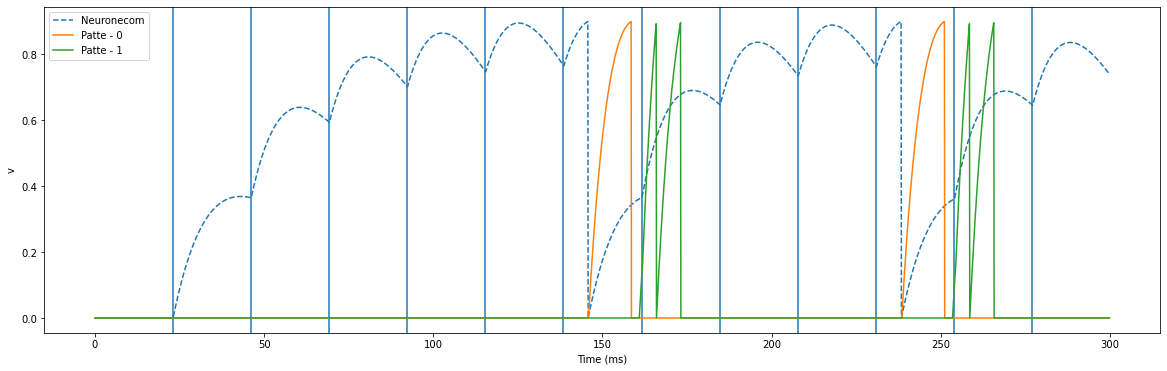

In [17]:
net.restore('2')
capteurs["neuroneCapteur"][3].I=1
net.run(300*ms)

visualiser()
visualiserDetailCapteur(3)

#### Fin - Merci pour votre attention